In [1]:
import bayes3d as b
import jax.numpy as jnp
import os
import torch
import numpy as np
import pickle
import warnings
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, build_sam
import sys
sys.path.extend(["/home/nishadgothoskar/ptamp/pybullet_planning"])
sys.path.extend(["/home/nishadgothoskar/ptamp"])
warnings.filterwarnings("ignore")


bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img('52', '1', bop_ycb_dir)

test_pkl_file = os.path.join(j.utils.get_assets_dir(),"sample_imgs/strawberry_error.pkl")
test_pkl_file = os.path.join(j.utils.get_assets_dir(),"sample_imgs/knife_spoon_box_real.pkl")
test_pkl_file = os.path.join(j.utils.get_assets_dir(),"sample_imgs/red_lego_multi.pkl")
test_pkl_file = os.path.join(j.utils.get_assets_dir(),"sample_imgs/demo2_nolight.pkl")

file = open(test_pkl_file,'rb')
camera_images = pickle.load(file)["camera_images"]
images = [j.RGBD.construct_from_camera_image(c) for c in camera_images]
rgbd = images[0]


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


pybullet build time: May 20 2022 19:44:17


In [2]:
j.get_rgb_image(rgbd.rgb).save("rgb.png")


In [3]:

sam = build_sam(checkpoint="/home/nishadgothoskar/jax3dp3/assets/sam/sam_vit_h_4b8939.pth")
sam.to(device="cuda")


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [26]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
#     points_per_side=32,
#     pred_iou_thresh=0.90,
#     stability_score_thresh=0.95,
#     crop_n_layers=0,
#     crop_n_points_downscale_factor=1,
#     min_mask_region_area=200,  # Requires open-cv to run post-processing
)

In [27]:
image = np.array(rgbd.rgb)
masks = mask_generator.generate(image)


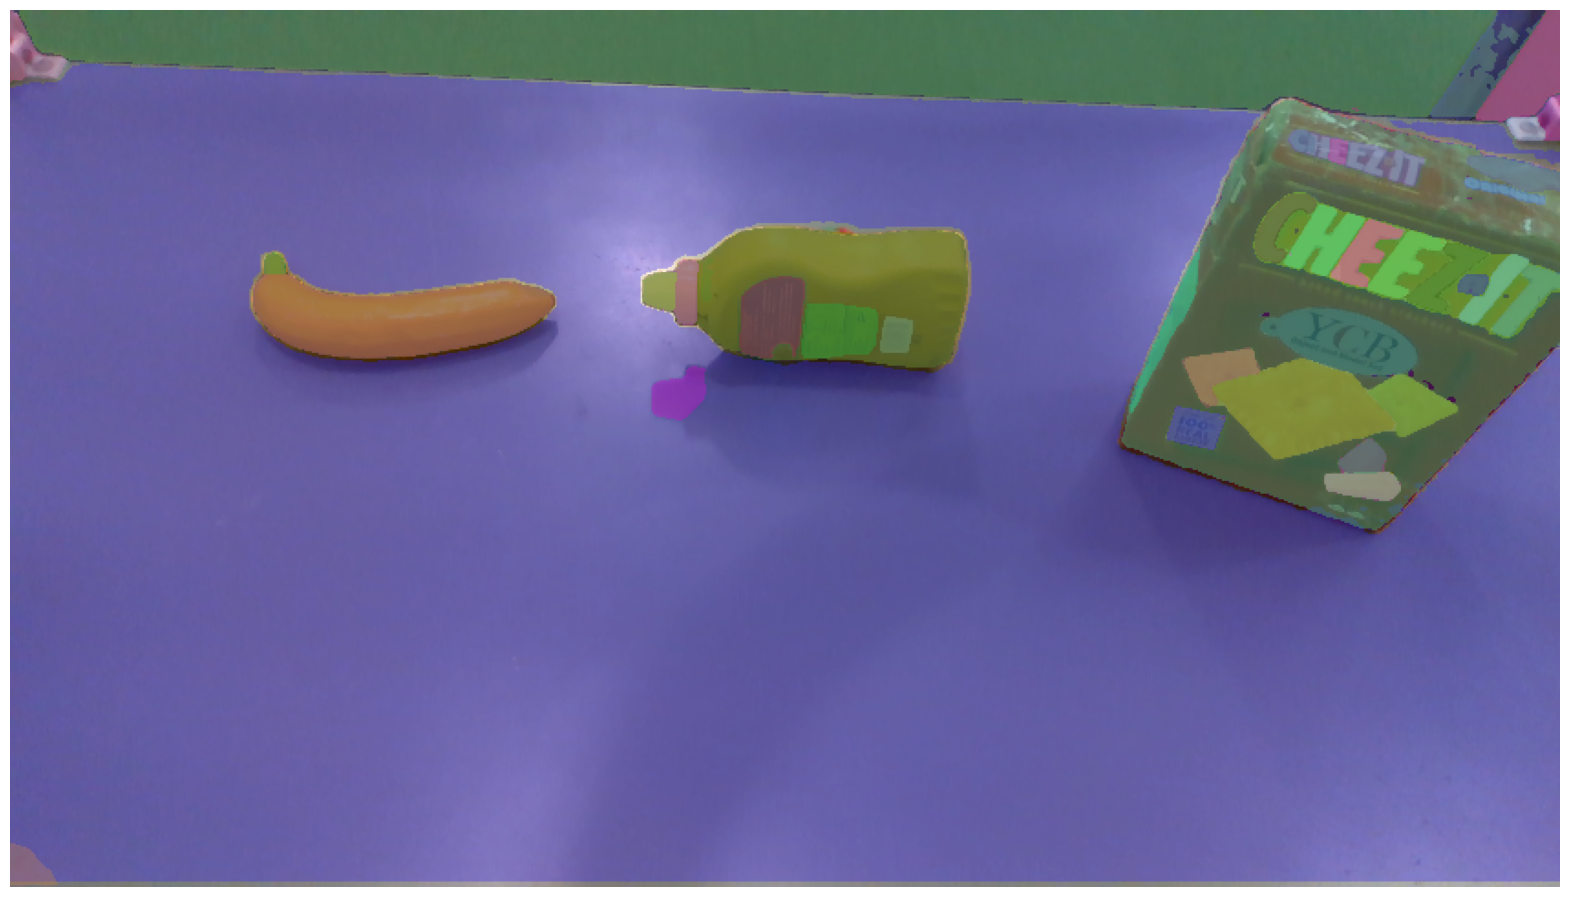

In [28]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [31]:
viz_images = []
full_segmentation = jnp.ones(rgbd.rgb.shape[:2]) * -1.0
num_objects_so_far = 0
for i in range(len(masks)):
    seg_mask = jnp.array(masks[i]["segmentation"])

    matched = False
    for jj in range(num_objects_so_far):
        seg_mask_existing_object = (full_segmentation == jj)
        
        intersection = seg_mask * seg_mask_existing_object
        if intersection[seg_mask].mean() > 0.9:
            matched = True
    
    if not matched:
        full_segmentation = full_segmentation.at[seg_mask].set(num_objects_so_far)
        num_objects_so_far += 1

    segmentation_image = j.get_depth_image(full_segmentation + 1,max=full_segmentation.max() + 2)
    seg_viz = j.get_depth_image(seg_mask)
    viz_images.append(j.hstack_images([segmentation_image, seg_viz]))

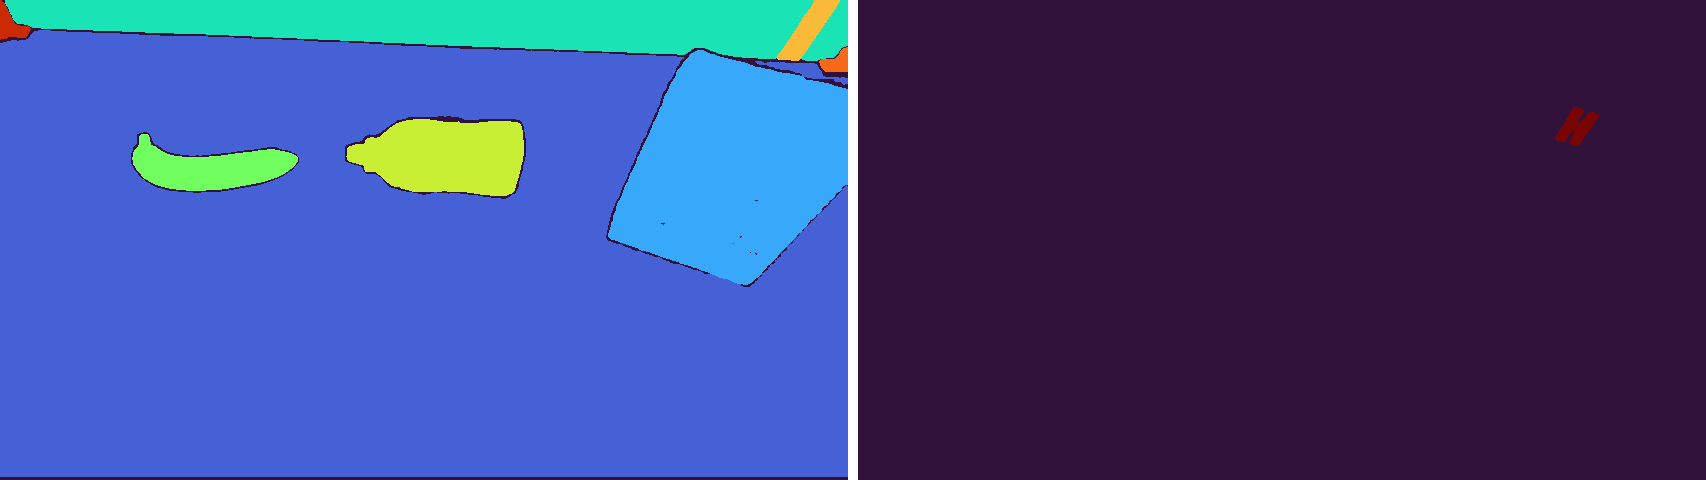

In [37]:
viz_images[-21]